# 数据预处理 & 特征工程

## Import

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

In [188]:
fp = 'scrapy\LianJiaSpider\data.csv'
raw_data = pd.read_csv(fp)
raw_data.head()

,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year
0,93.00,板塔结合,南,有,高楼层 (共30层),长安,集中供暖,101117686545,3室2厅1厨1卫,长安,其他,两梯四户,钢混结构,165.0,NaN,17742.0,普通住宅,NaN
1,129.00,板塔结合,南 北,有,中楼层 (共33层),长安,集中供暖,101117686563,3室1厅1厨2卫,长安,其他,两梯四户,未知结构,230.0,平层,17830.0,普通住宅,NaN
2,99.16,板塔结合,南 北,有,中楼层 (共31层),曲江,集中供暖,101117686600,3室2厅1厨1卫,雁塔,其他,两梯四户,钢混结构,195.0,平层,19666.0,普通住宅,NaN
3,99.00,塔楼,南 北,有,高楼层 (共26层),曲江,集中供暖,101117686611,3室2厅1厨1卫,雁塔,其他,三梯八户,钢混结构,149.0,NaN,15051.0,普通住宅,NaN
4,77.00,板塔结合,南 北,有,中楼层 (共34层),曲江,集中供暖,101117686628,2室1厅1厨1卫,雁塔,其他,两梯四户,钢混结构,170.0,NaN,22078.0,普通住宅,NaN


## Overview

### overview

In [189]:
display(raw_data.info(),
      raw_data.describe())

missing=raw_data[raw_data.isnull().T.any()].shape[0]
print('存在缺失值的样本数: ',missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        3000 non-null   float64
 1   building    2753 non-null   object 
 2   direction   3000 non-null   object 
 3   elevator    2466 non-null   object 
 4   floor       3000 non-null   object 
 5   garden      3000 non-null   object 
 6   heating     2784 non-null   object 
 7   _id         3000 non-null   int64  
 8   layout      2891 non-null   object 
 9   region      3000 non-null   object 
 10  renovation  2891 non-null   object 
 11  stairway    2880 non-null   object 
 12  structure   2891 non-null   object 
 13  totalPrice  3000 non-null   float64
 14  type        2212 non-null   object 
 15  unitPrice   3000 non-null   float64
 16  usage       3000 non-null   object 
 17  year        2170 non-null   object 
dtypes: float64(3), int64(1), object(14)
memory usage: 422.0+ KB


None

,area,_id,totalPrice,unitPrice
count,3000.000000,3.000000e+03,3000.000000,3000.000000
mean,97.183177,1.011176e+11,165.913633,15950.192667
std,41.354313,4.914710e+04,148.927421,6827.146937
min,10.000000,1.011175e+11,5.000000,2597.000000
25%,73.282500,1.011176e+11,90.000000,11222.250000
50%,93.260000,1.011176e+11,136.500000,14981.500000
75%,119.782500,1.011177e+11,195.000000,19091.000000
max,450.770000,1.011177e+11,3200.000000,99878.000000


存在缺失值的样本数:  1307


In [190]:
before_missing=raw_data.isnull().sum().sort_values(ascending=False)
print('各特征的缺失值个数：\n',before_missing)
before_missing=before_missing[before_missing>0]

各特征的缺失值个数：
 year          830
type          788
elevator      534
building      247
heating       216
stairway      120
structure     109
layout        109
renovation    109
usage           0
unitPrice       0
totalPrice      0
area            0
_id             0
garden          0
floor           0
direction       0
region          0
dtype: int64


* 目标变量: `totalprice` 
* `year`, `type`, `elevator` 缺失数据较多
* `area` 极值偏离实际且极差较大

### `area` 
异常原因可能是数据中包含了车库、别墅等特殊房型，故将其排除

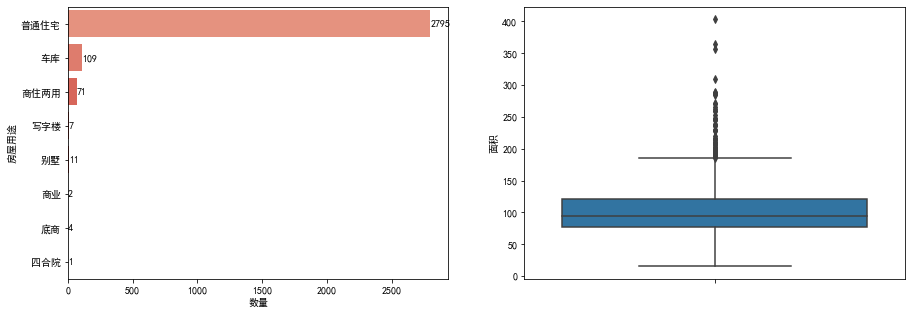

In [191]:
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(15, 5))
usage_bar=sns.countplot(data=raw_data,y='usage',palette='Reds_d',ax=ax1)
ax1.bar_label(usage_bar.containers[0])
ax1.set_ylabel('房屋用途')
ax1.set_xlabel('数量')

data = raw_data[(raw_data['usage'] == '普通住宅') | (raw_data['usage'] == '商住两用') |
                (raw_data['usage'] == '四合院')].copy()
sns.boxplot(data=data,y='area',ax=ax2)
ax2.set_ylabel('面积')
plt.savefig('./img/area_usage.eps',\
    format='eps',bbox_inches='tight',pad_inches=0.0)
plt.show()

In [192]:
data[data['area']>400]

,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year
2167,403.44,NaN,南 北,NaN,低楼层 (共3层),长安,NaN,101117604283,5室3厅1厨4卫,长安,简装,一梯一户,未知结构,1150.0,复式,28505.0,普通住宅,满两年


手动查询发现，因为信息登记不规范，id: 101117604283仍是独栋别墅，单独去除

In [193]:
data.drop(data.query('_id ==101117604283').index,inplace=True)
data[data['area']>400]

,area,building,direction,elevator,floor,garden,heating,_id,layout,region,renovation,stairway,structure,totalPrice,type,unitPrice,usage,year


### `direction`
`direction` 的数据较为杂乱，同一朝向出现多次，还有无空格和空格间隔交替出现的情况\
自定义 `sortDirect` 函数统一整理，并统一顺序

In [194]:
data['direction'].value_counts(dropna=False)

南 北            1262
南               775
北               150
东南              124
西南               98
东                87
西                74
西北               45
东北               36
北 南              32
东 南              25
东 西              23
南 西              17
东 北              14
东南 南             14
西 北              14
南 西南             10
南 西 北            10
东 南 北             8
西 南               5
南 东南              4
东 东南              4
北 东北              3
南 西北              3
南 北 西             2
东南 北              2
东 南 西             2
西 南 北             2
西南 西              2
东 西 北             2
东南 东              2
西北 东北             1
北 东               1
南 北 东南            1
西北 北              1
西 东               1
东南 西              1
东 东南 南 西南 西       1
北 东 西             1
东南 西南             1
东 东南 北            1
东 东南 南            1
南 东               1
北 西北              1
西南 北              1
东南 南 北            1
Name: direction, dtype: int64

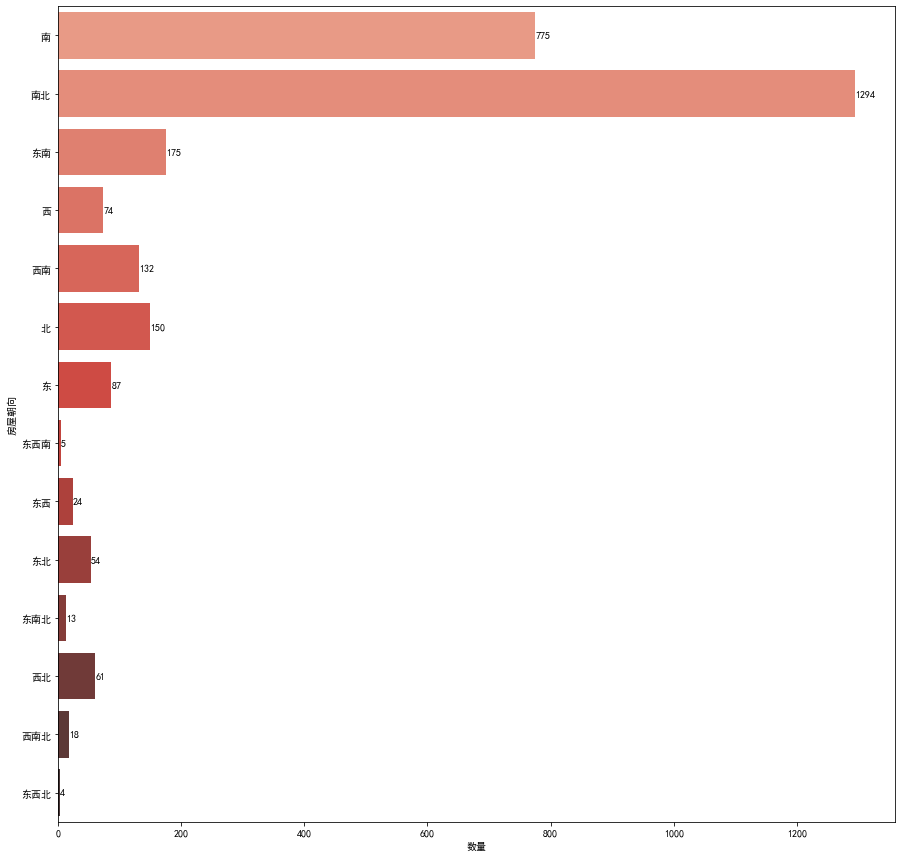

In [195]:
def sortDirect(x):
    d_list1 = ['东','西','南','北']
    d_list2 = ['东西','东南','东北','西南','西北','南北']
    d_list3 = ['东西南','东西北','东南北','西南北']
    d_list4 = ['东西南北']
    x=x.replace(' ','')
    d_set=set(x)
    for d_list in [d_list4,d_list3,d_list2,d_list1]:
        for d in d_list:
            if set(d)==d_set:
                return d

data['direction']=data['direction'].apply(sortDirect)

plt.figure(figsize=(15,15))
direction_bar=sns.countplot(data=data,y='direction',palette='Reds_d')
plt.bar_label(direction_bar.containers[0])
plt.ylabel('房屋朝向')
plt.xlabel('数量')
plt.savefig('./img/direction.eps',\
    format='eps',bbox_inches='tight',pad_inches=0.0)
plt.show()


### `elevator` -> `building_height`
* 缺失值处理\
&ensp;&ensp;依据：根据房屋所在楼的高度，若高于6层一般会加装电梯
* 独热(one-hot)处理

In [196]:
data['building_height'] = data['floor'].str.extract(r'共(\d+)层').astype('int')
data.loc[(data['elevator'].isnull()) & (data['building_height'] > 6),
         'elevator'] = '有'
data.loc[(data['elevator'].isnull()) & (data['building_height'] > 6),
         'elevator'] = '无'
data['elevator']=data['elevator'].apply(lambda x:1 if x=='有' else 0)
data['elevator'].value_counts()

1    2530
0     336
Name: elevator, dtype: int64

### `floor` -> `est_floor`
`floor` 的信息为“低中高”楼层\
利用 `elevator` 部分中提取的 `building_height` 估算房屋的楼高 `est_floor`\
低楼层取1/3 中楼层取2/3 高楼取总高度

In [197]:
data['floor'].value_counts(dropna=False)

高楼层 (共33层)    174
低楼层 (共33层)    160
中楼层 (共33层)    156
高楼层 (共6层)     102
高楼层 (共32层)     94
             ... 
中楼层 (共4层)       1
低楼层 (共36层)      1
中楼层 (共36层)      1
中楼层 (共41层)      1
高楼层 (共43层)      1
Name: floor, Length: 102, dtype: int64

In [198]:
data['est_floor']=data['building_height']*1.0
data[data['floor'].str[0]=='低']['est_floor']=\
    data[data['floor'].str[0]=='低']['est_floor']/3
data[data['floor'].str[0]=='中']['est_floor']=\
    data[data['floor'].str[0]=='中']['est_floor']*2/3
data['est_floor']=data['est_floor'].round().astype('int')
display(data['est_floor'])

C:\Users\19317\AppData\Local\Temp\ipykernel_11104\256116416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['floor'].str[0]=='低']['est_floor']=\
C:\Users\19317\AppData\Local\Temp\ipykernel_11104\256116416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['floor'].str[0]=='中']['est_floor']=\


0       30
1       33
2       31
3       26
4       34
        ..
2995    34
2996    26
2997    32
2998    28
2999     7
Name: est_floor, Length: 2866, dtype: int32

### `layout` -> `layout_room`, `layout_hall`, `layout_kitchen`, `layout_bathroom`
链家的信息登记较规范，格式为“X室X厅X厨X卫”，无缺失值\
因此用正则表达式提取即可

In [199]:
display(data['layout'].value_counts(dropna=False))
data[['layout_room','layout_hall','layout_kitchen','layout_bathroom']]=\
    data['layout'].str.extract(r'(\d*)室(\d*)厅+(\d*)厨(\d*)卫+').astype('int')
display(data[['_id','totalPrice','area','layout_room','layout_hall','layout_kitchen','layout_bathroom']].head())

2室1厅1厨1卫    594
3室2厅1厨2卫    515
2室2厅1厨1卫    483
3室2厅1厨1卫    291
1室1厅1厨1卫    186
3室1厅1厨1卫    173
4室2厅1厨2卫    173
3室1厅1厨2卫    134
1室0厅1厨1卫    106
2室2厅1厨2卫     39
2室1厅1厨2卫     25
4室2厅1厨3卫     21
4室1厅1厨2卫     21
1室0厅0厨1卫     12
3室2厅1厨3卫     11
1室2厅1厨1卫      9
5室2厅1厨3卫      7
4室2厅1厨1卫      5
4室2厅1厨4卫      4
1室1厅0厨1卫      4
4室1厅1厨4卫      4
2室0厅1厨1卫      3
4室1厅1厨3卫      3
5室2厅1厨2卫      2
3室1厅1厨3卫      2
5室1厅1厨2卫      2
4室1厅1厨1卫      2
1室0厅0厨0卫      2
4室2厅2厨3卫      2
3室1厅0厨1卫      1
5室2厅1厨1卫      1
4室2厅2厨2卫      1
4室0厅1厨4卫      1
4室3厅1厨4卫      1
2室1厅0厨2卫      1
3室3厅1厨2卫      1
5室3厅1厨4卫      1
6室3厅1厨2卫      1
5室2厅1厨4卫      1
2室1厅0厨0卫      1
4室2厅0厨2卫      1
4室3厅1厨3卫      1
6室2厅1厨2卫      1
1室0厅0厨2卫      1
3室2厅0厨0卫      1
2室0厅0厨0卫      1
6室3厅1厨3卫      1
4室1厅1厨5卫      1
6室2厅2厨8卫      1
4室4厅2厨2卫      1
5室3厅1厨3卫      1
5室1厅1厨3卫      1
3室1厅2厨2卫      1
3室2厅2厨2卫      1
6室2厅2厨3卫      1
2室1厅1厨0卫      1
2室1厅0厨1卫      1
5室3厅1厨2卫      1
6室2厅2厨4卫      1
3室3厅1厨1卫      1
Name: layout, dtype: int64

,_id,totalPrice,area,layout_room,layout_hall,layout_kitchen,layout_bathroom
0,101117686545,165.0,93.00,3,2,1,1
1,101117686563,230.0,129.00,3,1,1,2
2,101117686600,195.0,99.16,3,2,1,1
3,101117686611,149.0,99.00,3,2,1,1
4,101117686628,170.0,77.00,2,1,1,1


### `stairway` -> `perStair`
`stairway` 的格式为“X梯X户”，因搭配较多不利于模型训练\
修改策略: 新增一列 `perStair` 表示平均多少户共用一梯

In [200]:
def char2num(x):
    num_dict={
        '一':'1','二':'2','两':'2',
        '三':'3','四':'4','五':'5',
        '六':'6','七':'7','八':'8',
        '九':'9','十':'0',
    }
    if '十' in x:
        if x[0]=='十':
            num_str='1'+num_dict[x[-1]]
        else:
            num_str=num_dict[x[0]]+num_dict[x[-1]]
    else:
        num_str=num_dict[x[0]]
    return float(num_str)

data['stairway'].value_counts(dropna=False)
num_char=r'[一两二三四五六七八九十]'
df=data['stairway'].str.extract(f'({num_char}+)梯({num_char}+)户')
data['perStair']=df[1].apply(char2num)/df[0].apply(char2num)
display(data['stairway'].value_counts(dropna=False),data['perStair'])

两梯四户      707
一梯两户      443
两梯六户      199
两梯三户      152
一梯四户      151
         ... 
四梯五户        1
五梯十五户       1
两梯二十三户      1
三梯二十八户      1
三梯三十三户      1
Name: stairway, Length: 141, dtype: int64

0       2.000000
1       2.000000
2       2.000000
3       2.666667
4       2.000000
          ...   
2995    2.000000
2996    2.500000
2997    4.000000
2998    3.000000
2999    2.000000
Name: perStair, Length: 2866, dtype: float64

### `type`
缺失值填充&ensp;&ensp;依据：
* 根据房屋构造，一厨且面积较小(<100)或一卫的一般是平层
* 单独判断面积较大(>250)和较少(<100)的房屋
* 余下的缺失值难以判断

In [201]:
data['type'].value_counts(dropna=False)

平层     2086
NaN     659
复式       86
跃层       29
错层        6
Name: type, dtype: int64

In [202]:
data.loc[(data['type'].isnull())&(data['layout_bathroom']==1),'type']='平层'
data.loc[(data['type'].isnull())&(data['layout_kitchen']==1)\
    &(data['area']<100),'type']='平层'
display(data.loc[(data['type'].isnull())&((data['area']<100)|(data['area']>250)),['_id','area','type','layout']])
data.loc[data['_id']==101117538394,'type']='复式'
data.loc[data['_id']==101117671441,'type']='跃层'
display(data.loc[data['type'].isnull(),['_id','area','type','layout']])

,_id,area,type,layout
198,101117678707,270.00,NaN,5室3厅1厨3卫
392,101117671441,288.00,NaN,5室2厅1厨3卫
1683,101117538394,96.97,NaN,1室0厅0厨2卫
2670,101117671008,96.28,NaN,2室1厅0厨0卫


,_id,area,type,layout
6,101117686673,122.90,NaN,3室2厅1厨2卫
8,101117686701,110.00,NaN,3室2厅1厨2卫
13,101117686758,161.00,NaN,3室2厅1厨2卫
19,101117686315,133.67,NaN,3室2厅1厨2卫
26,101117686501,153.08,NaN,3室2厅1厨2卫
...,...,...,...,...
2973,101117685169,128.69,NaN,3室2厅1厨2卫
2983,101117685381,160.00,NaN,4室2厅1厨2卫
2990,101117685993,106.00,NaN,2室1厅1厨2卫
2993,101117686031,146.00,NaN,3室2厅1厨2卫


### `year`
缺失值填充\
&ensp;&ensp;依据：同一片地区的建筑建设时间大致相同

In [203]:
yearMode=data.groupby('garden')['year'].agg(pd.Series.mode)
display(yearMode)
for garden in yearMode.index:
    mode=yearMode[garden]
    if not isinstance(mode,str):
        if len(mode)==0:
            mode=None
        else:
            mode=mode[0]
    data.loc[(data['year'].isnull())&(data['garden']==garden),'year']=mode

garden
世博园       [未满两年, 满两年]
临潼               未满两年
北客站               满两年
半坡立交      [未满两年, 满五年]
南稍门               满五年
唐延路               满五年
国际港务区            未满两年
城东                满五年
城内                满五年
城北                满五年
城南                满五年
城西                满两年
太白南路              满五年
安装四处              满五年
广泰门               满两年
户县                满五年
曲江                满两年
未央湖               满两年
李家村               满五年
洪庆        [未满两年, 满五年]
浐河西路              满五年
浐灞周边             未满两年
矿山路               满两年
科技六路              满五年
紫薇田园都市            满五年
纺织城               满五年
经开北        [满两年, 满五年]
经开南               满五年
草滩               未满两年
蓝田                满五年
西咸               未满两年
逸翠园        [满两年, 满五年]
都市之门              满两年
锦业路               满五年
长安                满两年
陕西大会堂             满两年
雁南                满两年
雁鸣湖              未满两年
高新一中              满五年
高新三小              满五年
高新六路              满五年
高新四路              满五年
高新软件城              []
高陵                满五年
鱼化寨               满两年
黄雁村

### 剩余部分
`building` ,`type` 和 `year` 的缺失值较少且难以填充，故舍去

In [220]:
data.loc[data['totalPrice']>1500,'totalPrice']

1991    2368.0
2601    3200.0
Name: totalPrice, dtype: float64

In [204]:
after_missing=data.isnull().sum().sort_values(ascending=False)
print('剩余缺失值分布：\n',after_missing)
after_missing=after_missing[after_missing>0]
data.dropna(subset=['building','heating','type','year'],inplace=True)

剩余缺失值分布：
 type               209
building           125
heating            101
year                 2
area                 0
layout_bathroom      0
layout_kitchen       0
layout_hall          0
layout_room          0
est_floor            0
building_height      0
usage                0
unitPrice            0
structure            0
totalPrice           0
stairway             0
renovation           0
region               0
layout               0
_id                  0
garden               0
floor                0
elevator             0
direction            0
perStair             0
dtype: int64


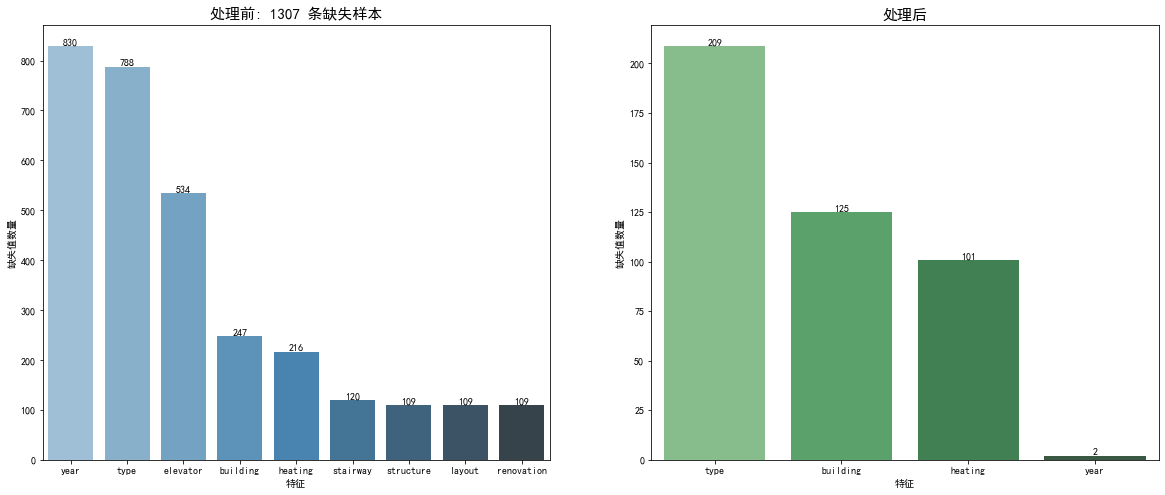

In [212]:
f, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 8))
bar1=sns.barplot(palette="Blues_d",\
    data=before_missing.to_frame('missing').T,ax=ax1)
ax1.bar_label(bar1.containers[0])
#plt.setp(ax1.get_xticklabels(), rotation=30)
ax1.set_xlabel('特征',fontsize=10)
ax1.set_ylabel('缺失值数量',fontsize=10)
ax1.set_title(f'处理前: {missing} 条缺失样本',fontsize=15)

bar2=sns.barplot(palette="Greens_d",\
    data=after_missing.to_frame('missing').T,ax=ax2)
ax2.bar_label(bar2.containers[0])
#plt.setp(ax2.get_xticklabels(), rotation=60)
ax2.set_xlabel('特征',fontsize=10)
ax2.set_ylabel('缺失值数量',fontsize=10)
ax2.set_title('处理后',fontsize=15)

plt.savefig('./img/missing.eps',\
    format='eps',bbox_inches='tight',pad_inches=0.0)
plt.show()

## Result
经预处理后剩余样本数为2544，\
无缺失值，大部分特征分布均匀

In [206]:
print('样本总量: ', data.shape[0])
display(data.head(),data.isnull().sum())

样本总量:  2544


,area,building,direction,elevator,floor,garden,heating,_id,layout,region,...,unitPrice,usage,year,building_height,est_floor,layout_room,layout_hall,layout_kitchen,layout_bathroom,perStair
0,93.00,板塔结合,南,1,高楼层 (共30层),长安,集中供暖,101117686545,3室2厅1厨1卫,长安,...,17742.0,普通住宅,满两年,30,30,3,2,1,1,2.000000
1,129.00,板塔结合,南北,1,中楼层 (共33层),长安,集中供暖,101117686563,3室1厅1厨2卫,长安,...,17830.0,普通住宅,满两年,33,33,3,1,1,2,2.000000
2,99.16,板塔结合,南北,1,中楼层 (共31层),曲江,集中供暖,101117686600,3室2厅1厨1卫,雁塔,...,19666.0,普通住宅,满两年,31,31,3,2,1,1,2.000000
3,99.00,塔楼,南北,1,高楼层 (共26层),曲江,集中供暖,101117686611,3室2厅1厨1卫,雁塔,...,15051.0,普通住宅,满两年,26,26,3,2,1,1,2.666667
4,77.00,板塔结合,南北,1,中楼层 (共34层),曲江,集中供暖,101117686628,2室1厅1厨1卫,雁塔,...,22078.0,普通住宅,满两年,34,34,2,1,1,1,2.000000


area               0
building           0
direction          0
elevator           0
floor              0
garden             0
heating            0
_id                0
layout             0
region             0
renovation         0
stairway           0
structure          0
totalPrice         0
type               0
unitPrice          0
usage              0
year               0
building_height    0
est_floor          0
layout_room        0
layout_hall        0
layout_kitchen     0
layout_bathroom    0
perStair           0
dtype: int64

## Insight

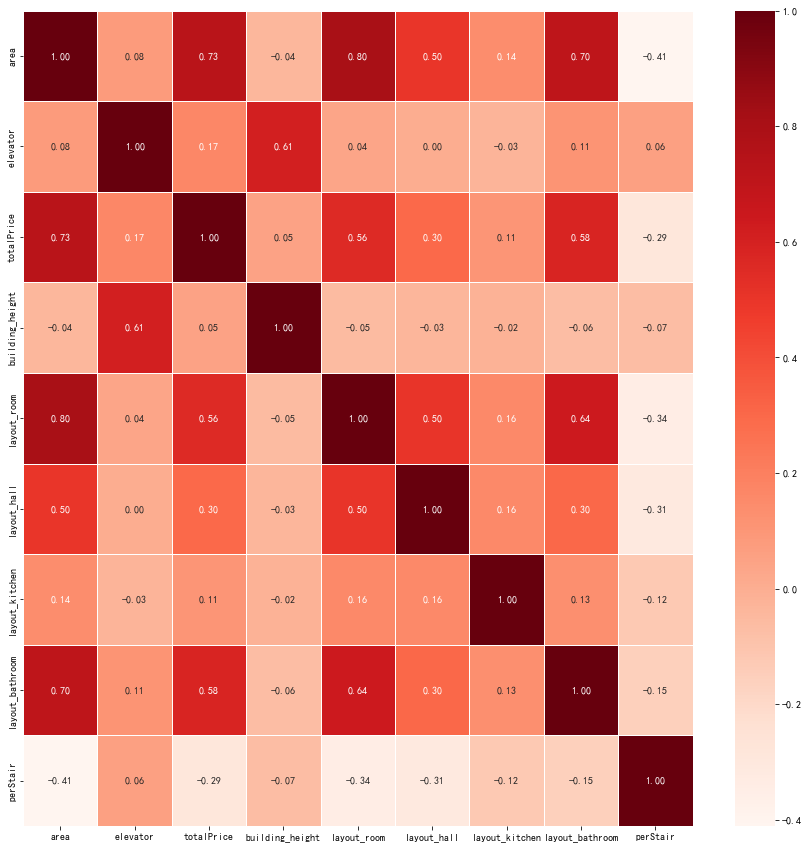

In [216]:
plt.figure(figsize=(15,15))
sns.heatmap(data.drop(['_id','unitPrice','est_floor'],axis=1).corr(),
            annot=True,  # 显示相关系数的数据
            fmt='.2f',  # 只显示两位小数
            linewidth=1,  # 设置每个单元格的距离
            cmap='Reds',  # 设置热力图颜色
            )
plt.savefig('./img/heatmap.eps',format='eps',
    bbox_inches='tight',pad_inches=0.0)
plt.show()

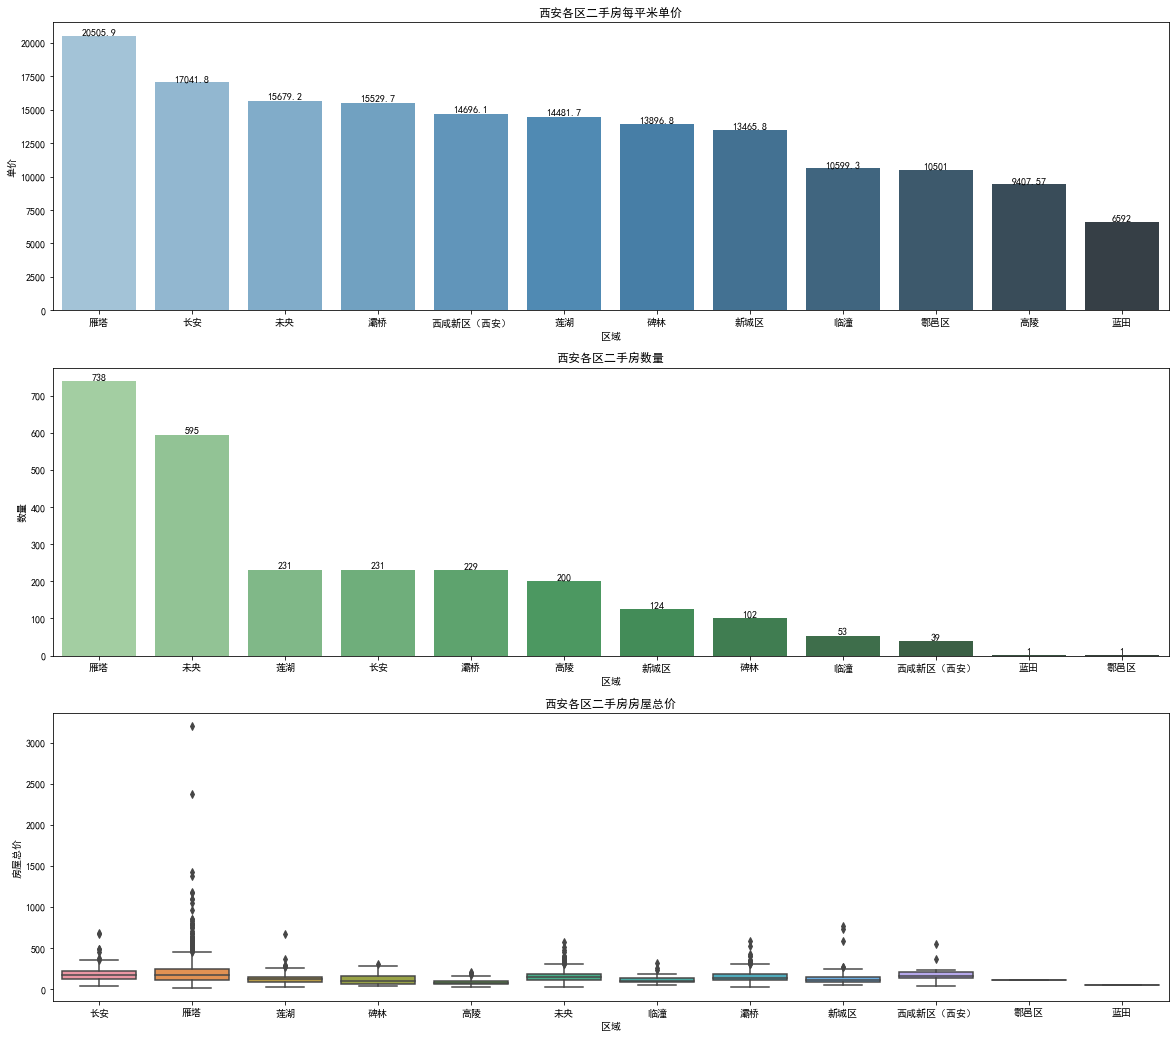

In [208]:
regionPrice=data.groupby('region')['unitPrice']\
    .mean().sort_values(ascending=False).to_frame().reset_index()
regionCount=data.groupby('region')['_id']\
    .count().sort_values(ascending=False).to_frame().reset_index()

f, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(20, 18))
bar1=sns.barplot(x='region',y='unitPrice',palette="Blues_d",\
    data=regionPrice,ax=ax1)
ax1.bar_label(bar1.containers[0])
ax1.set_xlabel('区域')
ax1.set_ylabel('单价')
ax1.set_title('西安各区二手房每平米单价')

bar2=sns.barplot(x='region',y='_id',palette="Greens_d",\
    data=regionCount,ax=ax2)
ax2.bar_label(bar2.containers[0])
ax2.set_xlabel('区域')
ax2.set_ylabel('数量')
ax2.set_title('西安各区二手房数量')

sns.boxplot(x='region', y='totalPrice', data=data, ax=ax3)
ax3.set_xlabel('区域')
ax3.set_ylabel('房屋总价')
ax3.set_title('西安各区二手房房屋总价')

plt.savefig('./img/insight.eps',\
    format='eps',bbox_inches='tight',pad_inches=0.0)
plt.show()

## One-hot & Save data
* `region`, `garden`, `renovation`, `heating`, `year`, `building`, `structure`, `type`, `direction` 这些字符变量需要独热处理
* 将 `cols` 中的特征保存到 `proccessed_data.csv` 中\
至此，数据才可用于模型训练

In [209]:
cols=['_id','totalPrice','area','region','garden','renovation',\
    'elevator','heating', 'building_height', 'est_floor','perStair',\
    'layout_room','layout_hall', 'layout_kitchen', 'layout_bathroom',\
    'year','building','structure','type','direction',]
outPut=data[cols]
outPut=pd.get_dummies(outPut,drop_first=True)
outPut.to_csv('proccessed_data.csv',index=False)